# Image Classification Using Neural Networks

## Project Name

### Overview

For the fourth phase, I put everything I've learned together to build a deep neural network that trains on a large dataset for classification on a non-trivial task. In this case, using x-ray images of pediatric patients to identify whether or not they have pneumonia. The dataset comes from [Kermany et al. on Mendeley](https://data.mendeley.com/datasets/rscbjbr9sj/3)


The images are split into a training set and a testing set of independent patients. Images are labeled as (disease)-(randomized patient ID)-(image number by this patient)

**Key facts**
- Pneumonia accounts for 14% of all deaths of children under 5 years old, killing 740 180 children in 2019
- Pneumonia can be caused by viruses, bacteria, or fungi.
- Pneumonia can be prevented by immunization, adequate nutrition, and by addressing environmental factors.
- Pneumonia caused by bacteria can be treated with antibiotics, but only one third of children with pneumonia receive the antibiotics they need.
- Pneumonia is a form of acute respiratory infection that affects the lungs. The lungs are made up of small sacs called alveoli, which fill with air when a healthy person breathes. When an individual has pneumonia, the alveoli are filled with pus and fluid, which makes breathing painful and limits oxygen intake.

**Pneumonia is the single largest infectious cause of death in children worldwide.** Pneumonia killed 740 180 children under the age of 5 in 2019, accounting for 14% of all deaths of children under five years old but 22% of all deaths in children aged 1 to 5. Pneumonia affects children and families everywhere, but deaths are highest in South Asia and sub-Saharan Africa. Children can be protected from pneumonia, it can be prevented with simple interventions, and treated with low-cost, low-tech medication and care.

## Business Area

Rural Hospitals and population-dense hospitals in Sri Lankajust recieved a large grant from the Bill and Melinda Gates foundation to purchase X Ray Machines for their practices. One of the largest problems present in these areas is the prevalence of pneumonia in their pediatric population, and the level of lethality it has for those children

## Problem

The Gates Foundation has the capital to provide the doctors with XRay Machines, but doctors have been widely complaining and criticizing the effort due to the huge volume of patients they see every day. The doctors don't have time to review all of the Xrays, and they don't have enough funding to high radiology techs.



In order to solve this issue, the Gates foundation called on us to build a model that can take in the Xray scans of a patient and automatically predict whether that pediatric patient has pneumonia. The Gates foundation envisions this becoming an automated process in which the xray machine atomatically uploads the image as a jpeg to be run through the model, and depending on the result automatically send the patient's family a notification and a prescription for antibiotics if needed.

# Imports

In [17]:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l2

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import tensorflow.keras.backend as K

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Review

Using loading process outlined in 

https://github.com/nicknochnack/ImageClassification/blob/main/Getting%20Started.ipynb

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Preparation

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory('./Data/CellData/chest_xray/train/',
                                                        label_mode='binary')

Found 3743 files belonging to 2 classes.
Metal device set to: Apple M1 Pro


2022-09-16 11:14:43.457728: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-16 11:14:43.457854: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
val_data = tf.keras.utils.image_dataset_from_directory('./Data/CellData/chest_xray/validation/',
                                                       label_mode='binary')

Found 1489 files belonging to 2 classes.


In [6]:
test_data = tf.keras.utils.image_dataset_from_directory('./Data/CellData/chest_xray/test/',
                                                       label_mode='binary')

Found 624 files belonging to 2 classes.


In [7]:
data_iterator = train_data.as_numpy_iterator()

In [8]:
batch = data_iterator.next()

2022-09-16 11:14:43.692982: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


/Users/charlielosche/miniforge3/envs/enf_tf/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


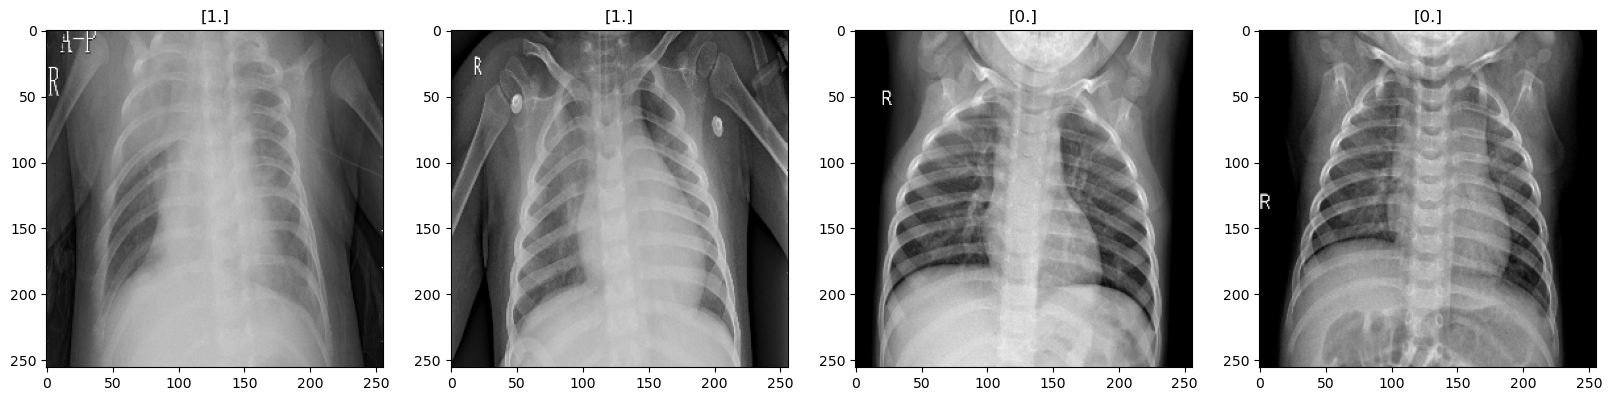

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Data Cleaning

### Scaling Data First

In [10]:
train_data = train_data.map(lambda x,y: (x/255, y))
test_data = test_data.map(lambda x,y: (x/255, y))
val_data = val_data.map(lambda x,y: (x/255, y))


In [11]:
train_data

<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [12]:
test_data

<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [13]:
val_data

<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

# Modeling

### TensorFlow with and without transfer learning

In [14]:
# Re-importing libraries to be safe
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [15]:
model = Sequential()

In [16]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# Train Model

In [15]:
logdir='logs'

In [16]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Check Training Performance

In [21]:
hist = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/20


2022-09-16 09:30:27.197052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - ETA: 0s - loss: 0.3598 - accuracy: 0.8461

2022-09-16 09:30:34.744007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - 10s 75ms/step - loss: 0.3598 - accuracy: 0.8461 - val_loss: 0.1267 - val_accuracy: 0.9530
Epoch 2/20
117/117 [==============================] - 9s 75ms/step - loss: 0.1264 - accuracy: 0.9538 - val_loss: 0.0949 - val_accuracy: 0.9637
Epoch 3/20
117/117 [==============================] - 9s 74ms/step - loss: 0.0937 - accuracy: 0.9674 - val_loss: 0.1508 - val_accuracy: 0.9436
Epoch 4/20
117/117 [==============================] - 9s 73ms/step - loss: 0.0920 - accuracy: 0.9685 - val_loss: 0.0876 - val_accuracy: 0.9671
Epoch 5/20
117/117 [==============================] - 9s 75ms/step - loss: 0.0580 - accuracy: 0.9797 - val_loss: 0.0797 - val_accuracy: 0.9711
Epoch 6/20
117/117 [==============================] - 9s 71ms/step - loss: 0.0667 - accuracy: 0.9760 - val_loss: 0.0792 - val_accuracy: 0.9718
Epoch 7/20
117/117 [==============================] - 9s 72ms/step - loss: 0.0444 - accuracy: 0.9853 - val_loss: 0.0987 - val_accuracy: 0.9664
Epoch 8/2

# Initial Model Performance

### Model Explainability

Lime - https://christophm.github.io/interpretable-ml-book/lime.html

Now that we have an initial model that has been fitted and trained, and we have a validation dataset to check if there is overfitting, let's see how it performed

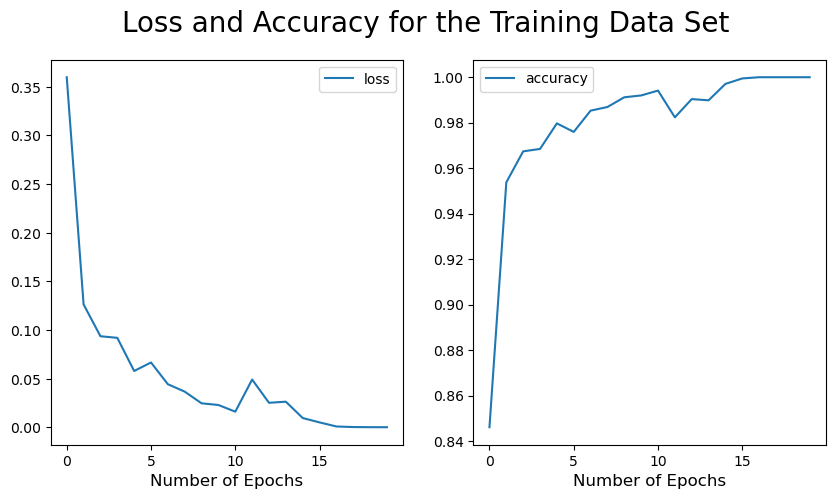

In [22]:
sigmoid_loss = hist.history['loss']
sigmoid_accuracy = hist.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=hist.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=hist.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
plt.suptitle('Loss and Accuracy for the Training Data Set', fontsize=20)
ax1.set_xlabel('Number of Epochs', loc='center', fontsize=12)
ax2.set_xlabel('Number of Epochs', loc='center', fontsize=12);

Now that we can see our model is performing well at generating a high level of accuracy and low level of loss, how does the model perform with regards to validation data to make sure it isn't overfitting (as CNNs tend to)

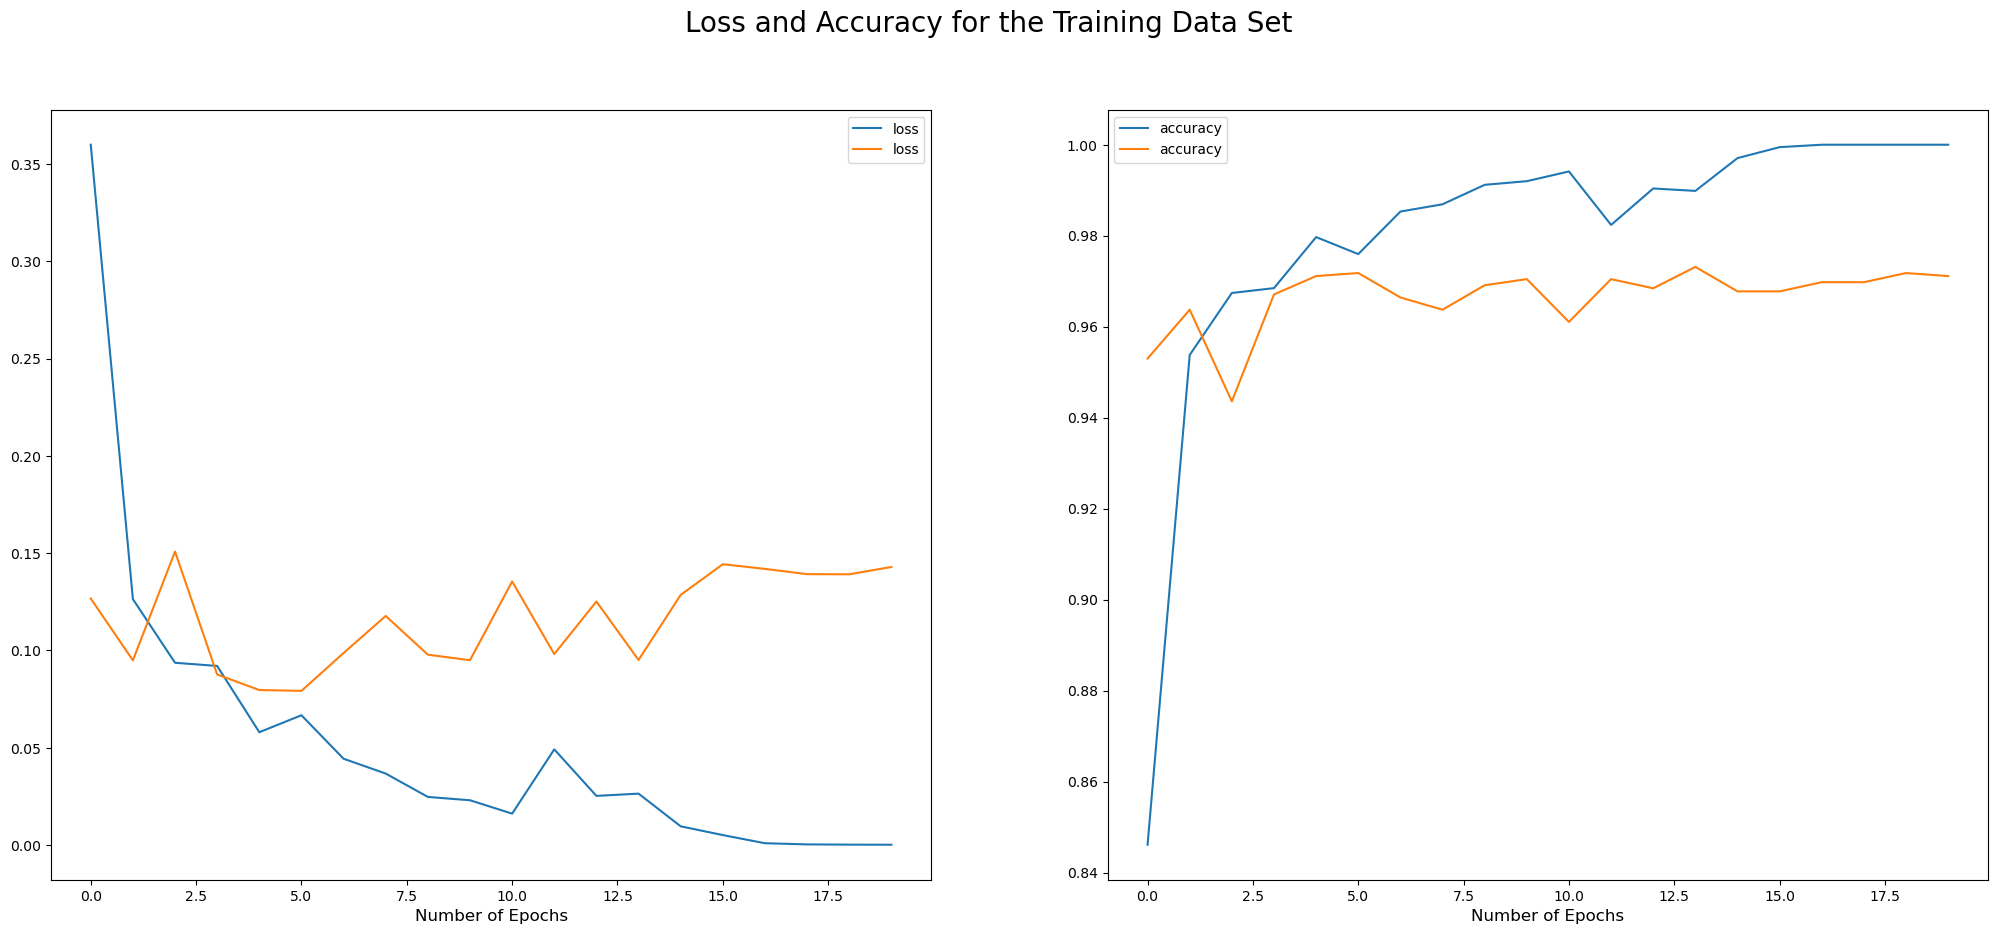

In [56]:
sigmoid_loss = hist.history['loss']
sigmoid_accuracy = hist.history['accuracy']
val_sigmoid_loss = hist.history['val_loss']
val_sigmoid_accuracy = hist.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
sns.lineplot(x=hist.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=hist.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
sns.lineplot(x=hist.epoch, y=val_sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=hist.epoch, y=val_sigmoid_accuracy, ax=ax2, label='accuracy')
plt.suptitle('Loss and Accuracy for the Training Data Set', fontsize=20)
ax1.set_xlabel('Number of Epochs', loc='center', fontsize=12)
ax2.set_xlabel('Number of Epochs', loc='center', fontsize=12);

It looks like our model needs to be better tuned in order to reduce the variability in loss that is occuring in the validation dataset, and to try and reduce the amount of overfitting occuring in the current model (leading to the lower level of accuracy on the validation dataset)

# Model Tuning

## Epoch and Batch Tuning

Since both our training datasets loss and accuracy leveled out, our model is likely no longer learning. with that said, our validataion loss and accuracy isn't performing as well as wel would like.


let's see if that is true - we will increase the number of epochs by 50% (to 30) and decrease batch sizeby around 50% (to 15 from 32)

In [24]:
model2 = Sequential()

model2.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model2.add(MaxPooling2D())
model2.add(Conv2D(32, (3,3), 1, activation='relu'))
model2.add(MaxPooling2D())
model2.add(Conv2D(16, (3,3), 1, activation='relu'))
model2.add(MaxPooling2D())
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
hist2 = model2.fit(train_data, epochs=30, batch_size=15, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/30


2022-09-16 09:33:28.566310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - ETA: 0s - loss: 0.3379 - accuracy: 0.8520

2022-09-16 09:33:35.989303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - 9s 75ms/step - loss: 0.3379 - accuracy: 0.8520 - val_loss: 0.1047 - val_accuracy: 0.9570
Epoch 2/30
117/117 [==============================] - 9s 75ms/step - loss: 0.1197 - accuracy: 0.9535 - val_loss: 0.1513 - val_accuracy: 0.9449
Epoch 3/30
117/117 [==============================] - 9s 74ms/step - loss: 0.1086 - accuracy: 0.9613 - val_loss: 0.0913 - val_accuracy: 0.9651
Epoch 4/30
117/117 [==============================] - 9s 74ms/step - loss: 0.0769 - accuracy: 0.9722 - val_loss: 0.0990 - val_accuracy: 0.9617
Epoch 5/30
117/117 [==============================] - 9s 72ms/step - loss: 0.0644 - accuracy: 0.9789 - val_loss: 0.0782 - val_accuracy: 0.9698
Epoch 6/30
117/117 [==============================] - 9s 73ms/step - loss: 0.0517 - accuracy: 0.9826 - val_loss: 0.0802 - val_accuracy: 0.9704
Epoch 7/30
117/117 [==============================] - 9s 73ms/step - loss: 0.0404 - accuracy: 0.9866 - val_loss: 0.1256 - val_accuracy: 0.9570
Epoch 8/30

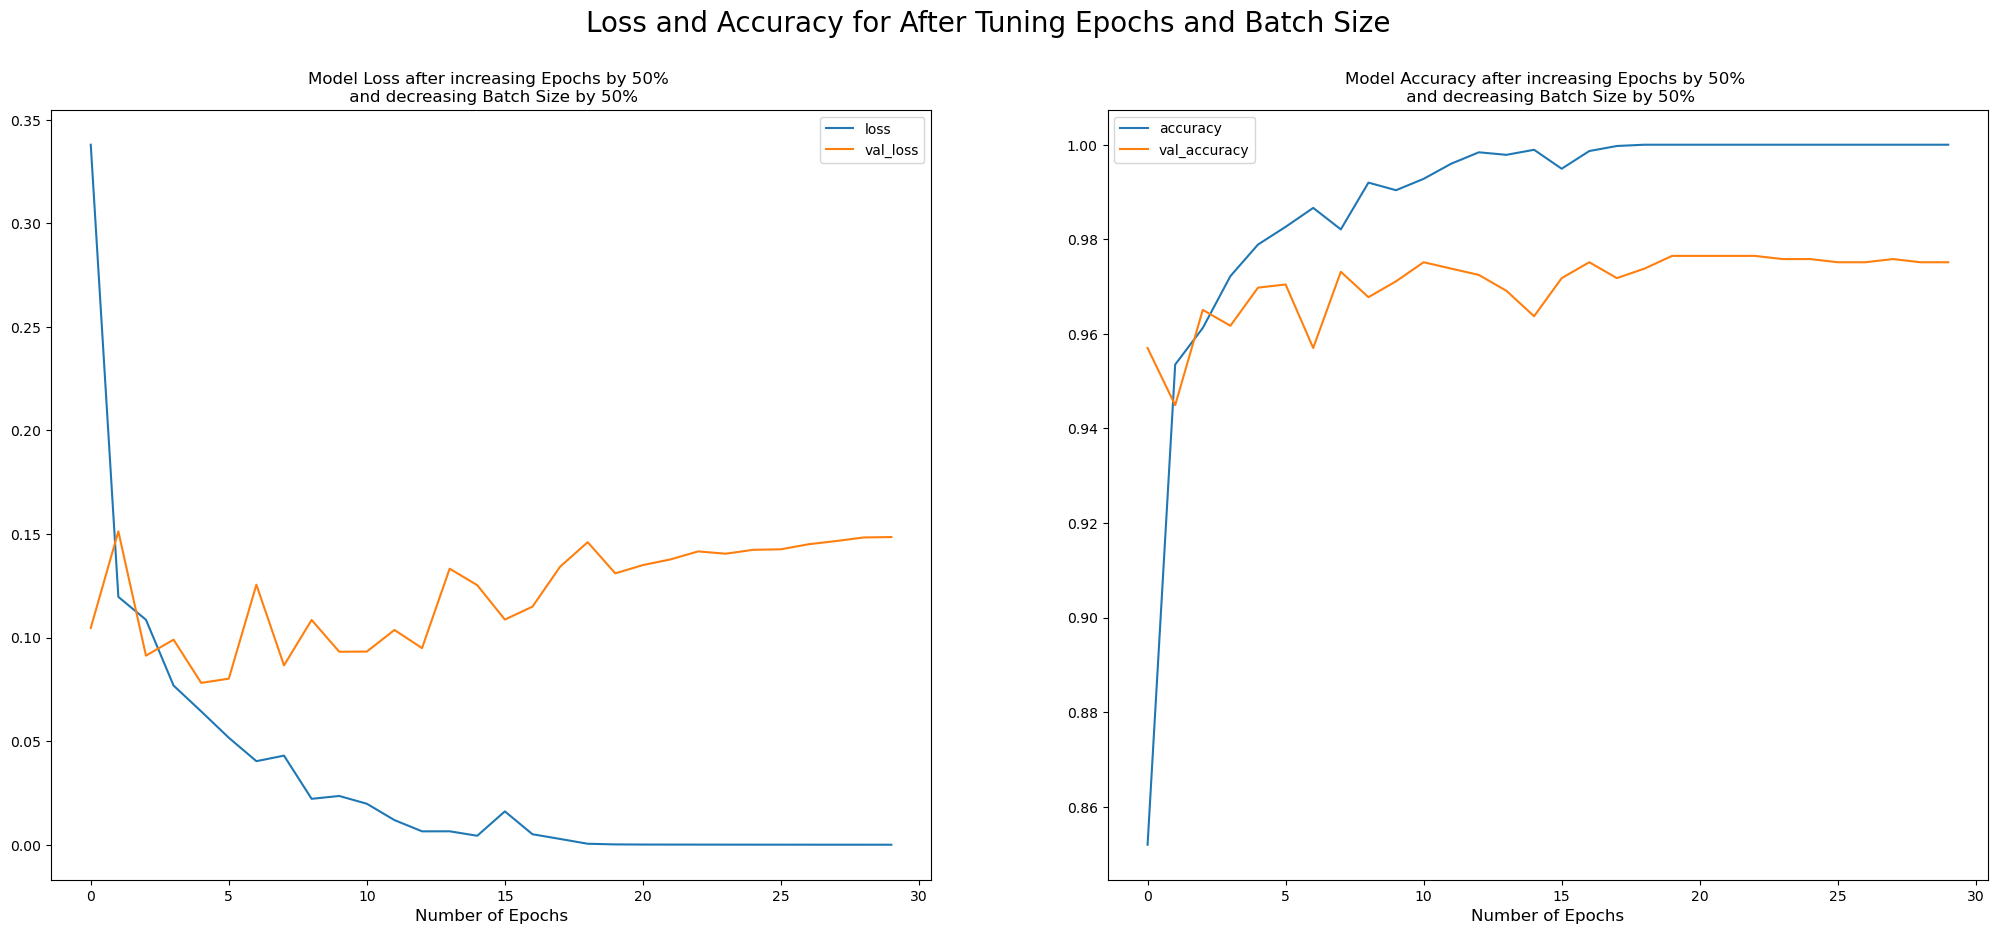

In [57]:
sigmoid_loss = hist2.history['loss']
sigmoid_accuracy = hist2.history['accuracy']
val_sigmoid_loss = hist2.history['val_loss']
val_sigmoid_accuracy = hist2.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
sns.lineplot(x=hist2.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=hist2.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
sns.lineplot(x=hist2.epoch, y=val_sigmoid_loss, ax=ax1, label='val_loss')
sns.lineplot(x=hist2.epoch, y=val_sigmoid_accuracy, ax=ax2, label='val_accuracy')
plt.suptitle('Loss and Accuracy for After Tuning Epochs and Batch Size', fontsize=20)
ax1.set_title('Model Loss after increasing Epochs by 50% \n and decreasing Batch Size by 50%', fontsize=12)
ax2.set_title('Model Accuracy after increasing Epochs by 50% \n and decreasing Batch Size by 50%', fontsize=12)
ax1.set_xlabel('Number of Epochs', loc='center', fontsize=12)
ax2.set_xlabel('Number of Epochs', loc='center', fontsize=12);

It looks like changing batch size and epochs did in fact improve accuracy (validation accuracy sitting at 96% instead of 95%), but changing batch size and epochs lead to worse performance on model loss for validation...


To try and improve loss, let's change the learning rate to account for the change in epochs and batch size, shrinking it by 50%

## Reducing learning rate to avoid missing the min learning rate

In [27]:
model3 = Sequential()

model3.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model3.add(MaxPooling2D())
model3.add(Conv2D(32, (3,3), 1, activation='relu'))
model3.add(MaxPooling2D())
model3.add(Conv2D(16, (3,3), 1, activation='relu'))
model3.add(MaxPooling2D())
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

adam = tf.keras.optimizers.Adam(learning_rate=0.0005)

model3.compile(optimizer=adam, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
hist3 = model3.fit(train_data, epochs=30, batch_size=15, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/30


2022-09-16 09:37:56.947537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - ETA: 0s - loss: 0.3355 - accuracy: 0.8421

2022-09-16 09:38:04.409207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - 9s 75ms/step - loss: 0.3355 - accuracy: 0.8421 - val_loss: 0.1350 - val_accuracy: 0.9550
Epoch 2/30
117/117 [==============================] - 9s 72ms/step - loss: 0.1262 - accuracy: 0.9503 - val_loss: 0.2281 - val_accuracy: 0.9214
Epoch 3/30
117/117 [==============================] - 9s 74ms/step - loss: 0.0962 - accuracy: 0.9650 - val_loss: 0.0936 - val_accuracy: 0.9577
Epoch 4/30
117/117 [==============================] - 9s 72ms/step - loss: 0.0811 - accuracy: 0.9719 - val_loss: 0.1142 - val_accuracy: 0.9597
Epoch 5/30
117/117 [==============================] - 9s 72ms/step - loss: 0.0714 - accuracy: 0.9762 - val_loss: 0.0839 - val_accuracy: 0.9671
Epoch 6/30
117/117 [==============================] - 9s 72ms/step - loss: 0.0657 - accuracy: 0.9781 - val_loss: 0.0804 - val_accuracy: 0.9704
Epoch 7/30
117/117 [==============================] - 9s 75ms/step - loss: 0.0600 - accuracy: 0.9792 - val_loss: 0.1005 - val_accuracy: 0.9617
Epoch 8/30

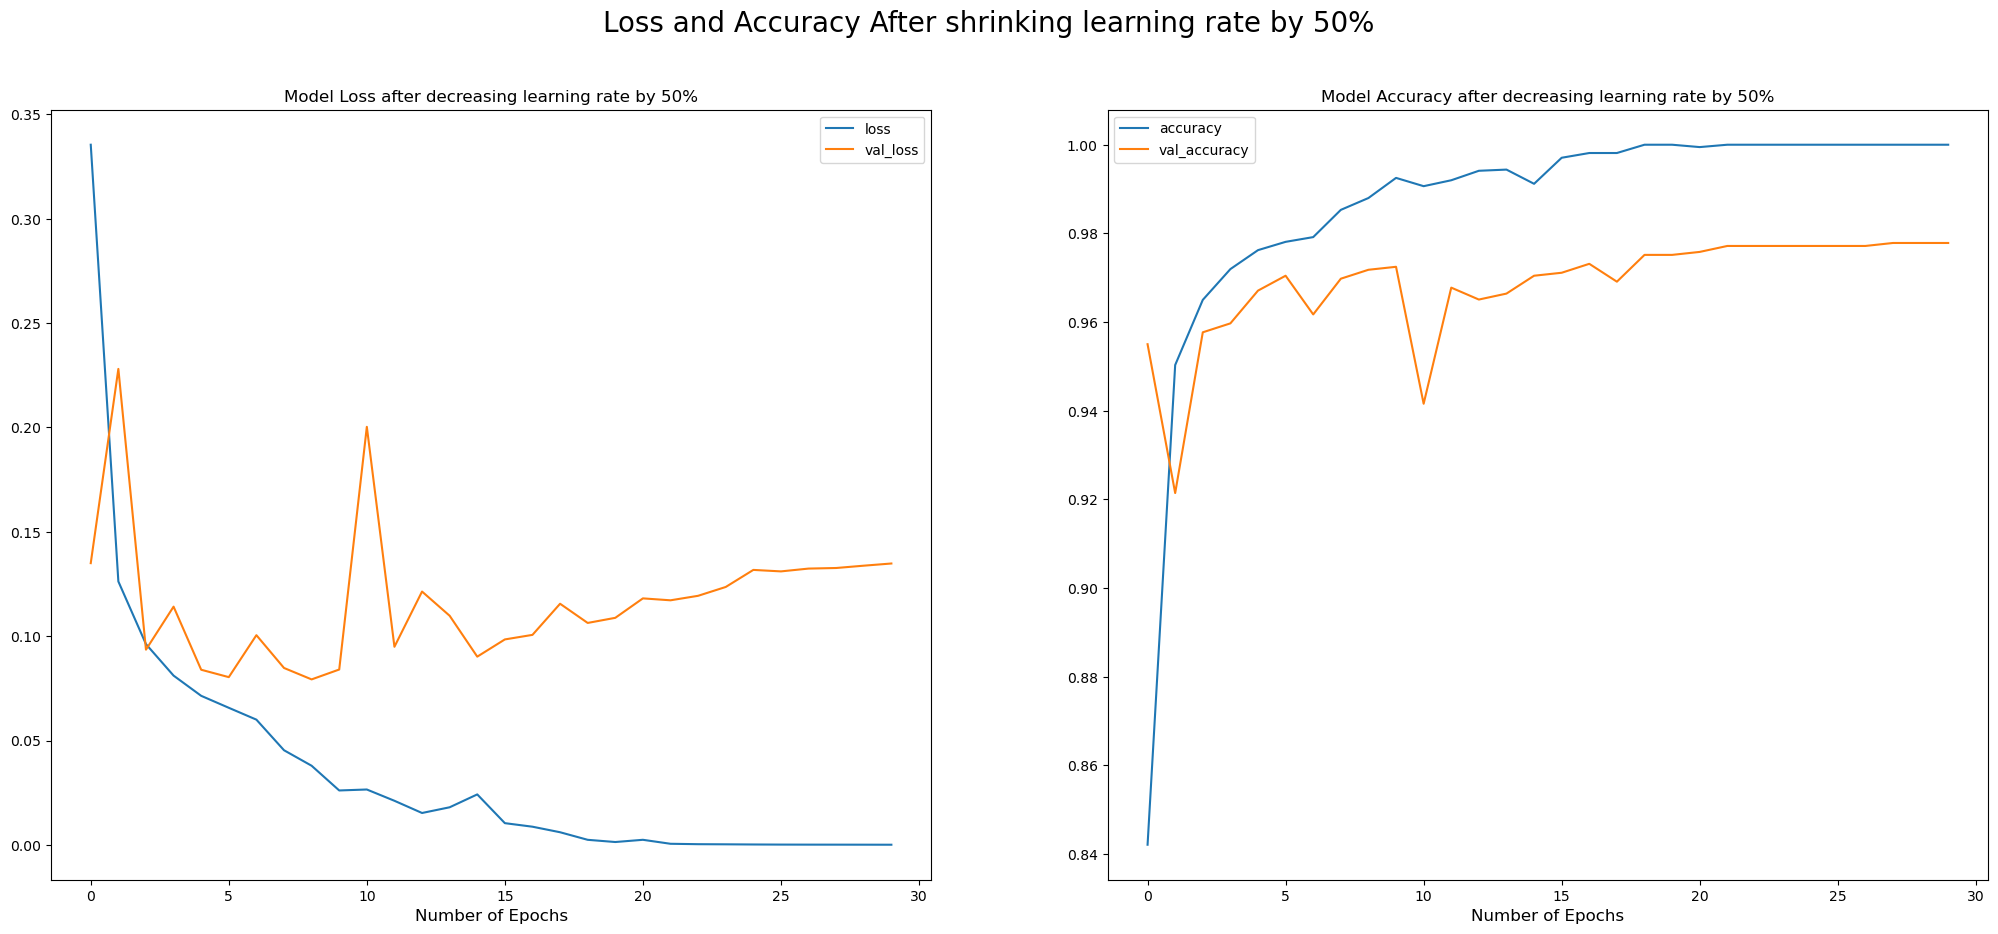

In [58]:
sigmoid_loss = hist3.history['loss']
sigmoid_accuracy = hist3.history['accuracy']
val_sigmoid_loss = hist3.history['val_loss']
val_sigmoid_accuracy = hist3.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
sns.lineplot(x=hist3.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=hist3.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
sns.lineplot(x=hist3.epoch, y=val_sigmoid_loss, ax=ax1, label='val_loss')
sns.lineplot(x=hist3.epoch, y=val_sigmoid_accuracy, ax=ax2, label='val_accuracy')
plt.suptitle('Loss and Accuracy After shrinking learning rate by 50%', fontsize=20)
ax1.set_title('Model Loss after decreasing learning rate by 50%', fontsize=12)
ax2.set_title('Model Accuracy after decreasing learning rate by 50%', fontsize=12)
ax1.set_xlabel('Number of Epochs', loc='center', fontsize=12)
ax2.set_xlabel('Number of Epochs', loc='center', fontsize=12);

I'm pretty happy with the change in the model loss and accuracy due to the reduced learning rate, but it seems now the # of epohcs isn't necessary. I'm going to introduce a different stopping function (from lab on regularization). To avoid too early of stopping, I'm going to use patience=5

## Adding Early Stopping Term

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-10,
                           verbose=1,
                           mode='min',
                           patience=5)

In [32]:
model4 = Sequential()

model4.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model4.add(MaxPooling2D())
model4.add(Conv2D(32, (3,3), 1, activation='relu'))
model4.add(MaxPooling2D())
model4.add(Conv2D(16, (3,3), 1, activation='relu'))
model4.add(MaxPooling2D())
model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

adam = tf.keras.optimizers.Adam(learning_rate=0.0005)

model4.compile(optimizer=adam, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [33]:
hist4 = model4.fit(train_data, epochs=20, batch_size=15, validation_data=val_data, callbacks=[early_stop])

Epoch 1/20


2022-09-16 09:42:27.027611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.8723

2022-09-16 09:42:34.935230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - 10s 81ms/step - loss: 0.2861 - accuracy: 0.8723 - val_loss: 0.2267 - val_accuracy: 0.9187
Epoch 2/20
117/117 [==============================] - 10s 83ms/step - loss: 0.1145 - accuracy: 0.9565 - val_loss: 0.0921 - val_accuracy: 0.9597
Epoch 3/20
117/117 [==============================] - 9s 75ms/step - loss: 0.0846 - accuracy: 0.9693 - val_loss: 0.0973 - val_accuracy: 0.9651
Epoch 4/20
117/117 [==============================] - 9s 73ms/step - loss: 0.0722 - accuracy: 0.9749 - val_loss: 0.0940 - val_accuracy: 0.9664
Epoch 5/20
117/117 [==============================] - 9s 73ms/step - loss: 0.0744 - accuracy: 0.9717 - val_loss: 0.0805 - val_accuracy: 0.9711
Epoch 6/20
117/117 [==============================] - 9s 74ms/step - loss: 0.0514 - accuracy: 0.9853 - val_loss: 0.0776 - val_accuracy: 0.9691
Epoch 7/20
117/117 [==============================] - 9s 72ms/step - loss: 0.0578 - accuracy: 0.9808 - val_loss: 0.0755 - val_accuracy: 0.9731
Epoch 8/

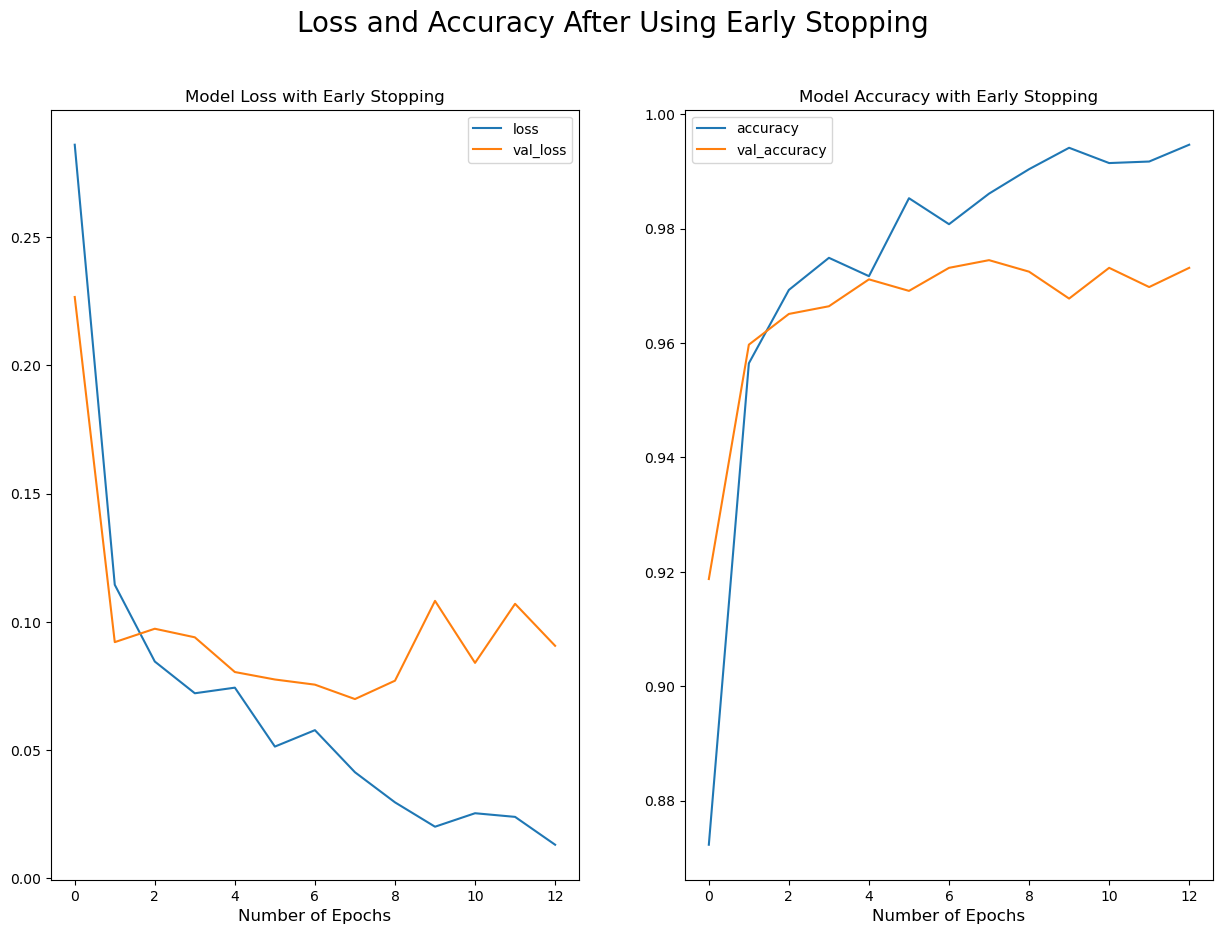

In [34]:
sigmoid_loss = hist4.history['loss']
sigmoid_accuracy = hist4.history['accuracy']
val_sigmoid_loss = hist4.history['val_loss']
val_sigmoid_accuracy = hist4.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
sns.lineplot(x=hist4.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=hist4.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
sns.lineplot(x=hist4.epoch, y=val_sigmoid_loss, ax=ax1, label='val_loss')
sns.lineplot(x=hist4.epoch, y=val_sigmoid_accuracy, ax=ax2, label='val_accuracy')
plt.suptitle('Loss and Accuracy After Using Early Stopping', fontsize=20)
ax1.set_title('Model Loss with Early Stopping', fontsize=12)
ax2.set_title('Model Accuracy with Early Stopping', fontsize=12)
ax1.set_xlabel('Number of Epochs', loc='center', fontsize=12)
ax2.set_xlabel('Number of Epochs', loc='center', fontsize=12);

Changing to the early stopping callback led to the model only performing a few epochs - that likely isn't enough to provide a strong outcome given unseen data. I'm not going to include the early stopping callback in the final model, instead I'll use the original tensorboard callback for visualizations.

## Regularization and additional Dense Layer

In [16]:
# Adding import of regularizer again to be safe

from tensorflow.keras.regularizers import l2

In [36]:
model5 = Sequential()

model5.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model5.add(MaxPooling2D())
model5.add(Conv2D(32, (3,3), 1, activation='relu'))
model5.add(MaxPooling2D())
model5.add(Conv2D(16, (3,3), 1, activation='relu'))
model5.add(MaxPooling2D())
model5.add(Flatten())
model5.add(Dense(256, activation='relu', kernel_regularizer=l2(l=.05)))
model5.add(Dense(128, activation='relu', kernel_regularizer=l2(l=.05)))
model5.add(Dense(1, activation='sigmoid'))

adam = tf.keras.optimizers.Adam(learning_rate=0.0005)

model5.compile(optimizer=adam, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [37]:
hist5 = model5.fit(train_data, epochs=20, batch_size=15, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/20


2022-09-16 09:44:26.348146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - ETA: 0s - loss: 7.7341 - accuracy: 0.8197

2022-09-16 09:44:34.206773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - 10s 79ms/step - loss: 7.7341 - accuracy: 0.8197 - val_loss: 2.3894 - val_accuracy: 0.8993
Epoch 2/20
117/117 [==============================] - 9s 78ms/step - loss: 1.3257 - accuracy: 0.9303 - val_loss: 0.6888 - val_accuracy: 0.9429
Epoch 3/20
117/117 [==============================] - 9s 76ms/step - loss: 0.4639 - accuracy: 0.9434 - val_loss: 0.3087 - val_accuracy: 0.9537
Epoch 4/20
117/117 [==============================] - 9s 75ms/step - loss: 0.2809 - accuracy: 0.9442 - val_loss: 0.2605 - val_accuracy: 0.9389
Epoch 5/20
117/117 [==============================] - 9s 75ms/step - loss: 0.2481 - accuracy: 0.9423 - val_loss: 0.1891 - val_accuracy: 0.9631
Epoch 6/20
117/117 [==============================] - 9s 73ms/step - loss: 0.2016 - accuracy: 0.9554 - val_loss: 0.2136 - val_accuracy: 0.9476
Epoch 7/20
117/117 [==============================] - 9s 75ms/step - loss: 0.1748 - accuracy: 0.9618 - val_loss: 0.1623 - val_accuracy: 0.9584
Epoch 8/2

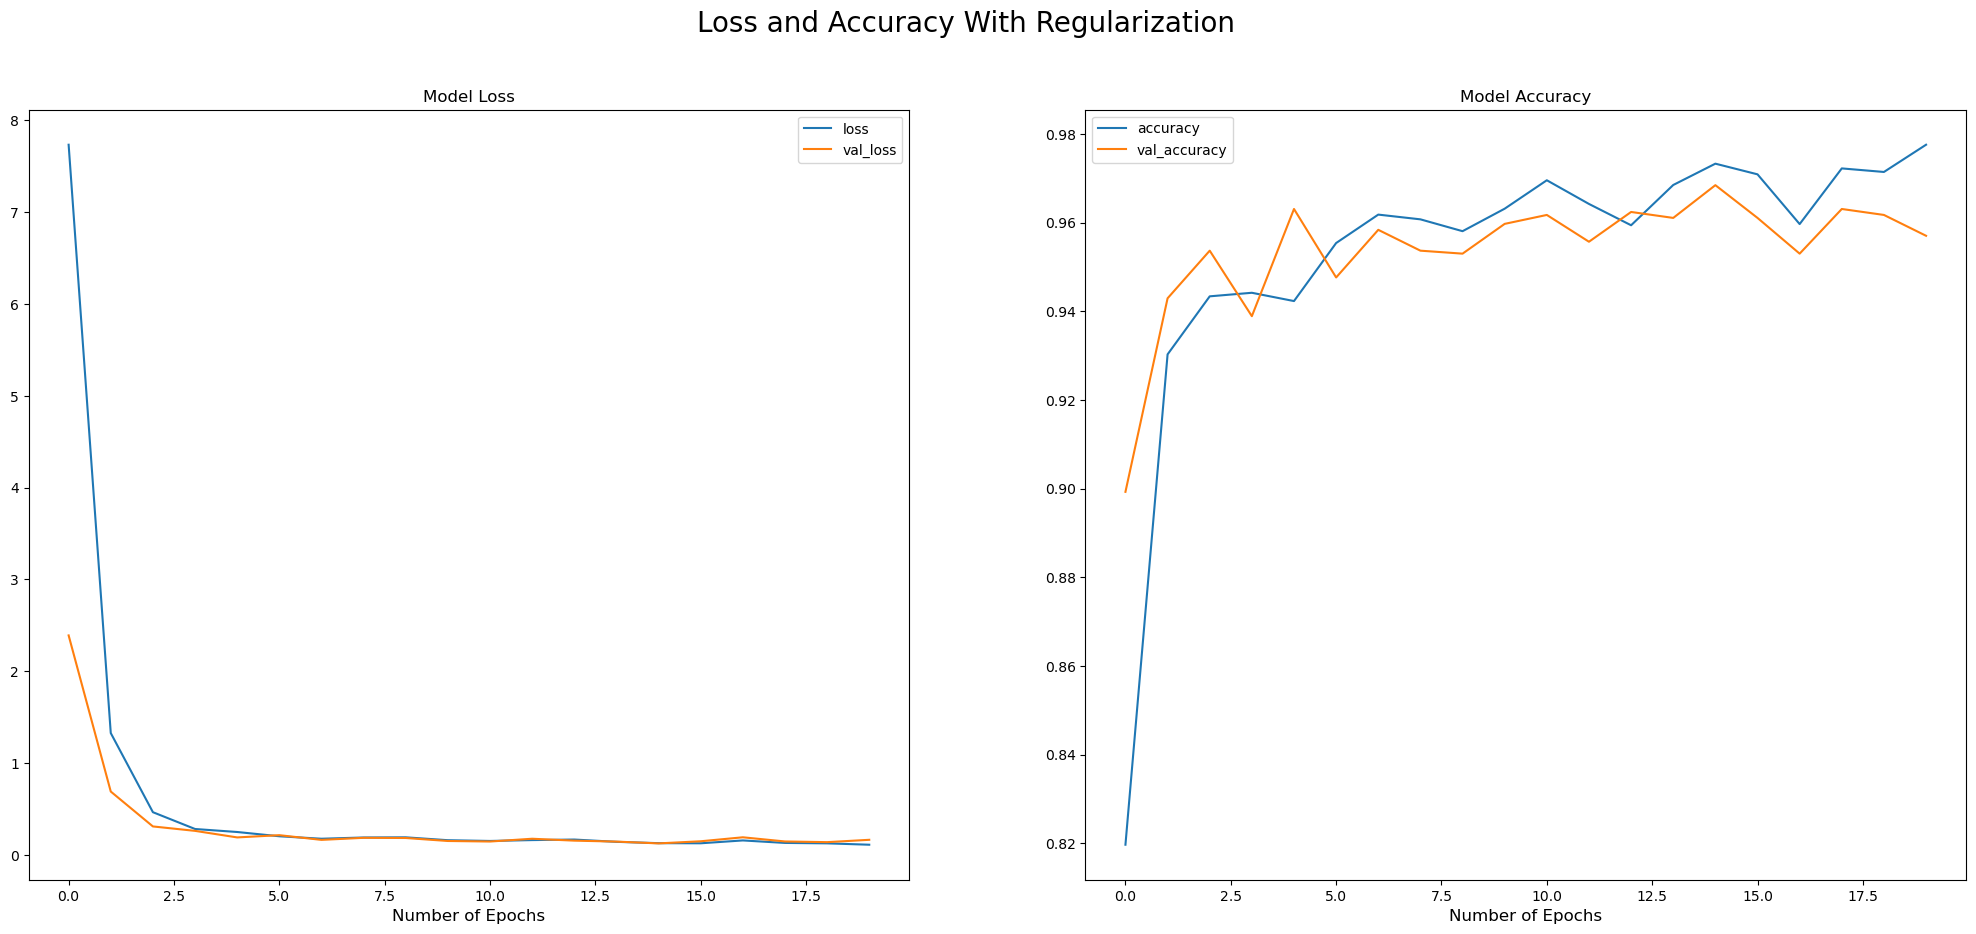

In [59]:
sigmoid_loss = hist5.history['loss']
sigmoid_accuracy = hist5.history['accuracy']
val_sigmoid_loss = hist5.history['val_loss']
val_sigmoid_accuracy = hist5.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
sns.lineplot(x=hist5.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=hist5.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
sns.lineplot(x=hist5.epoch, y=val_sigmoid_loss, ax=ax1, label='val_loss')
sns.lineplot(x=hist5.epoch, y=val_sigmoid_accuracy, ax=ax2, label='val_accuracy')
plt.suptitle('Loss and Accuracy With Regularization', fontsize=20)
ax1.set_title('Model Loss', fontsize=12)
ax2.set_title('Model Accuracy', fontsize=12)
ax1.set_xlabel('Number of Epochs', loc='center', fontsize=12)
ax2.set_xlabel('Number of Epochs', loc='center', fontsize=12);

In [39]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 16)      

Overall, the issue of overfitting has been addressed, with the L2 Regularization removing the poor results on the validation data's log loss. With that said, the variability in accuracy for the validation data makes me think the model isn't done learning now at 20 epochs. In the next model I'm going to:

- re-introduce early stopping
- ramp up epochs to 40 to see how the model performs
- change the L2 weight from .05 to .01


I never added any dropout terms since the results are already pretty variable, and since my overfitting issue has mostly been addressed

In [19]:
#Adding Variable Callback again to be safe in order to set model class value for learning rate
import tensorflow.keras.backend as K

In [41]:
model6 = Sequential()

model6.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model6.add(MaxPooling2D())
model6.add(Conv2D(32, (3,3), 1, activation='relu'))
model6.add(MaxPooling2D())
model6.add(Conv2D(16, (3,3), 1, activation='relu'))
model6.add(MaxPooling2D())
model6.add(Flatten())
model6.add(Dense(256, activation='relu', kernel_regularizer=l2(l=.01)))
model6.add(Dense(128, activation='relu', kernel_regularizer=l2(l=.01)))
model6.add(Dense(1, activation='sigmoid'))

model6.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

#in order to add multiple callbacks, need to set learning rate via Keras
K.set_value(model6.optimizer.lr, 5e-4)

In [42]:
hist6 = model6.fit(train_data, epochs=40, batch_size=15, validation_data=val_data, callbacks=[tensorboard_callback, early_stop])

Epoch 1/40


2022-09-16 09:47:33.596656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - ETA: 0s - loss: 2.0607 - accuracy: 0.8651

2022-09-16 09:47:41.395974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - 10s 77ms/step - loss: 2.0607 - accuracy: 0.8651 - val_loss: 0.8334 - val_accuracy: 0.9416
Epoch 2/40
117/117 [==============================] - 9s 77ms/step - loss: 0.6037 - accuracy: 0.9471 - val_loss: 0.4511 - val_accuracy: 0.9510
Epoch 3/40
117/117 [==============================] - 9s 75ms/step - loss: 0.3685 - accuracy: 0.9573 - val_loss: 0.3010 - val_accuracy: 0.9617
Epoch 4/40
117/117 [==============================] - 9s 77ms/step - loss: 0.3146 - accuracy: 0.9527 - val_loss: 0.2559 - val_accuracy: 0.9597
Epoch 5/40
117/117 [==============================] - 9s 74ms/step - loss: 0.2421 - accuracy: 0.9629 - val_loss: 0.3131 - val_accuracy: 0.9308
Epoch 6/40
117/117 [==============================] - 9s 74ms/step - loss: 0.2075 - accuracy: 0.9669 - val_loss: 0.1919 - val_accuracy: 0.9664
Epoch 7/40
117/117 [==============================] - 10s 79ms/step - loss: 0.1787 - accuracy: 0.9687 - val_loss: 0.1609 - val_accuracy: 0.9691
Epoch 8/

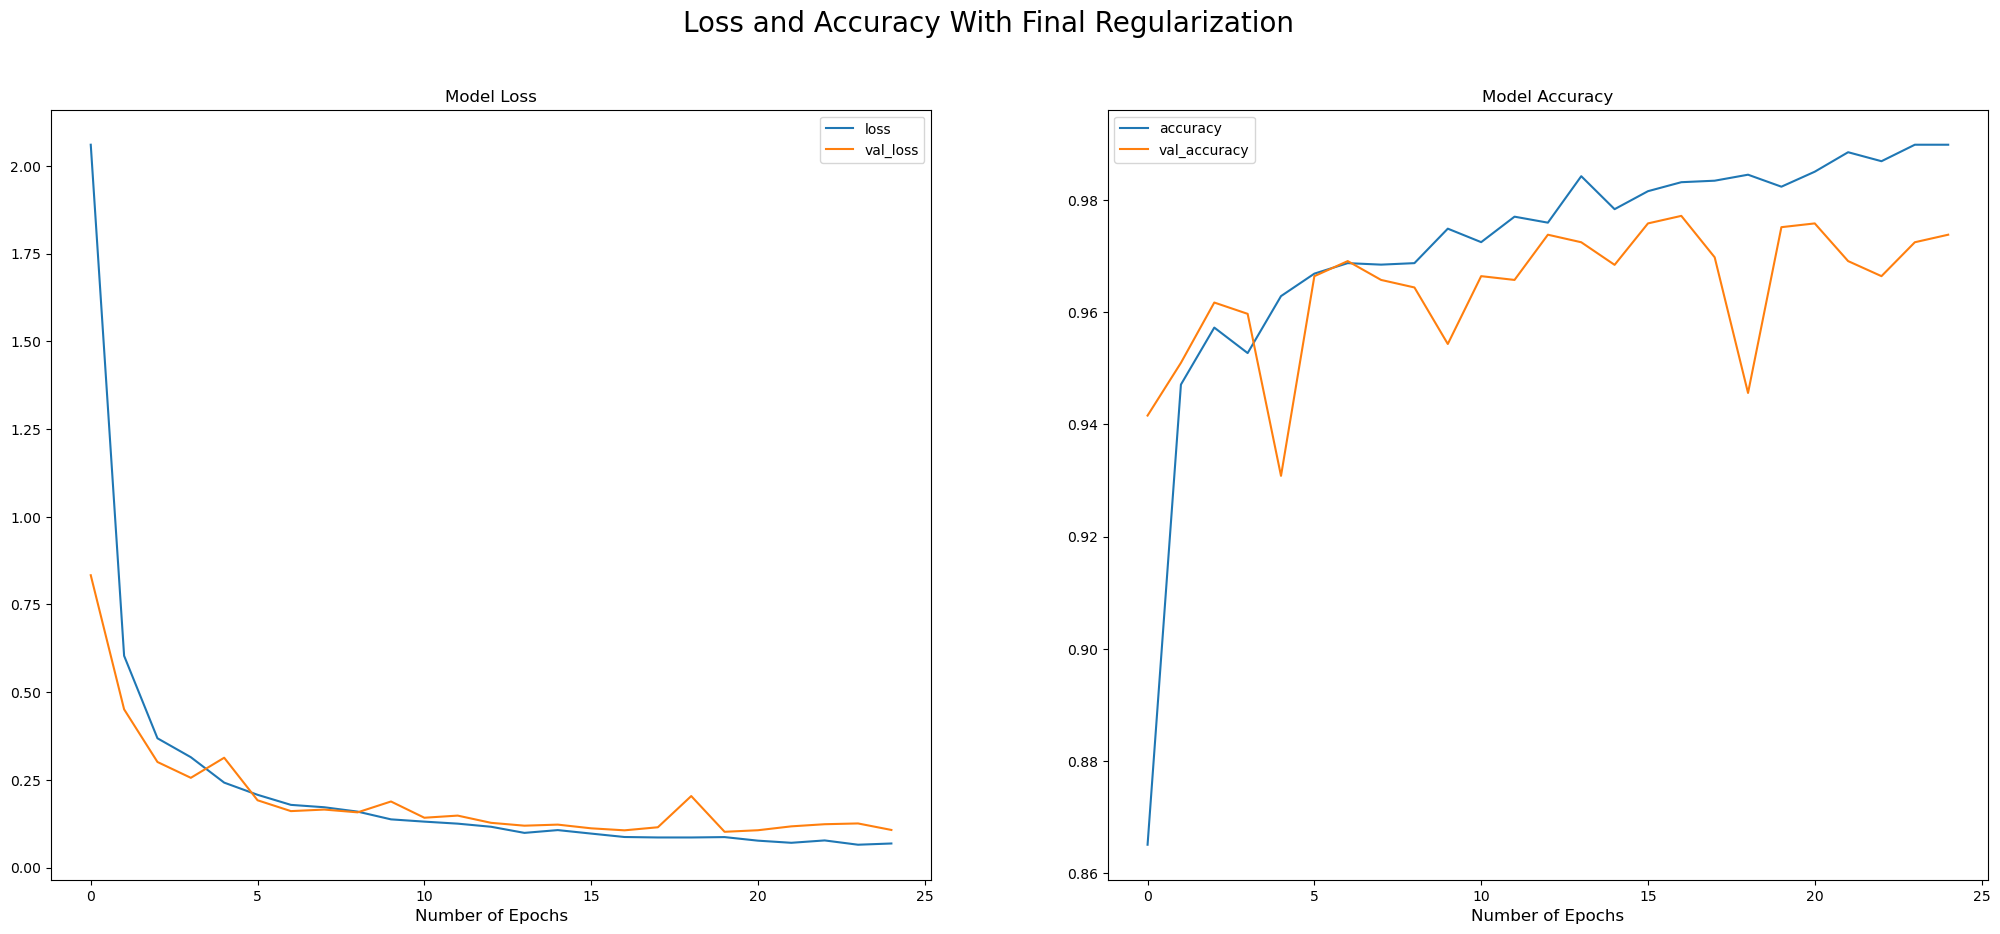

In [60]:
sigmoid_loss = hist6.history['loss']
sigmoid_accuracy = hist6.history['accuracy']
val_sigmoid_loss = hist6.history['val_loss']
val_sigmoid_accuracy = hist6.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
sns.lineplot(x=hist6.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=hist6.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy')
sns.lineplot(x=hist6.epoch, y=val_sigmoid_loss, ax=ax1, label='val_loss')
sns.lineplot(x=hist6.epoch, y=val_sigmoid_accuracy, ax=ax2, label='val_accuracy')
plt.suptitle('Loss and Accuracy With Final Regularization', fontsize=20)
ax1.set_title('Model Loss', fontsize=12)
ax2.set_title('Model Accuracy', fontsize=12)
ax1.set_xlabel('Number of Epochs', loc='center', fontsize=12)
ax2.set_xlabel('Number of Epochs', loc='center', fontsize=12);

# Final Model

Below is the final model we intend to share with the Gates Foundation for implementation

In [44]:
# # Update so that both training and validation data is used to fit final model for evaluation on test data

# final_train_data = tf.keras.utils.image_dataset_from_directory('../Data/CellData/chest_xray/total_train/',
#                                                                label_mode='binary')

# test_data = tf.keras.utils.image_dataset_from_directory('../Data/CellData/chest_xray/test/',
#                                                         label_mode='binary')

In [18]:
# updating to evaluate against validation accuracy and patience in early stopping in order to better generate model
early_stop2 = EarlyStopping(monitor='val_loss',
                            min_delta=1e-8,
                            verbose=1,
                            mode='min',
                            restore_best_weights=True,
                            patience=5)

In [23]:
# trying out some data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomFlip("vertical")
])

In [24]:
final_model = Sequential([data_augmentation])

final_model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
final_model.add(MaxPooling2D())
final_model.add(Conv2D(32, (3,3), 1, activation='relu'))
final_model.add(MaxPooling2D())
final_model.add(Conv2D(16, (3,3), 1, activation='relu'))
final_model.add(MaxPooling2D())
final_model.add(Flatten())
final_model.add(Dense(256, activation='relu', kernel_regularizer=l2(l=.01)))
final_model.add(Dense(128, activation='relu', kernel_regularizer=l2(l=.01)))
final_model.add(Dense(1, activation='sigmoid'))

final_model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

#in order to add multiple callbacks, need to set learning rate via Keras
K.set_value(final_model.optimizer.lr, 5e-4)

Changed to only use initial test data to train, whichwe know is better for generalizations

In [25]:
final_hist = final_model.fit(train_data, epochs=20, batch_size=32, validation_data=val_data, callbacks=[tensorboard_callback, early_stop2])

Epoch 1/20


2022-09-16 10:45:43.698296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - ETA: 0s - loss: 1.6727 - accuracy: 0.7945

2022-09-16 10:46:03.461086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


117/117 [==============================] - 22s 179ms/step - loss: 1.6727 - accuracy: 0.7945 - val_loss: 0.5896 - val_accuracy: 0.9261
Epoch 2/20
117/117 [==============================] - 21s 180ms/step - loss: 0.4502 - accuracy: 0.9199 - val_loss: 0.3390 - val_accuracy: 0.9355
Epoch 3/20
117/117 [==============================] - 21s 180ms/step - loss: 0.4223 - accuracy: 0.9060 - val_loss: 0.3191 - val_accuracy: 0.9436
Epoch 4/20
117/117 [==============================] - 22s 182ms/step - loss: 0.2930 - accuracy: 0.9329 - val_loss: 0.2313 - val_accuracy: 0.9563
Epoch 5/20
117/117 [==============================] - 22s 184ms/step - loss: 0.2759 - accuracy: 0.9378 - val_loss: 0.2607 - val_accuracy: 0.9342
Epoch 6/20
117/117 [==============================] - 22s 183ms/step - loss: 0.2424 - accuracy: 0.9396 - val_loss: 0.2495 - val_accuracy: 0.9295
Epoch 7/20
117/117 [==============================] - 22s 183ms/step - loss: 0.2290 - accuracy: 0.9396 - val_loss: 0.3994 - val_accuracy: 0.8

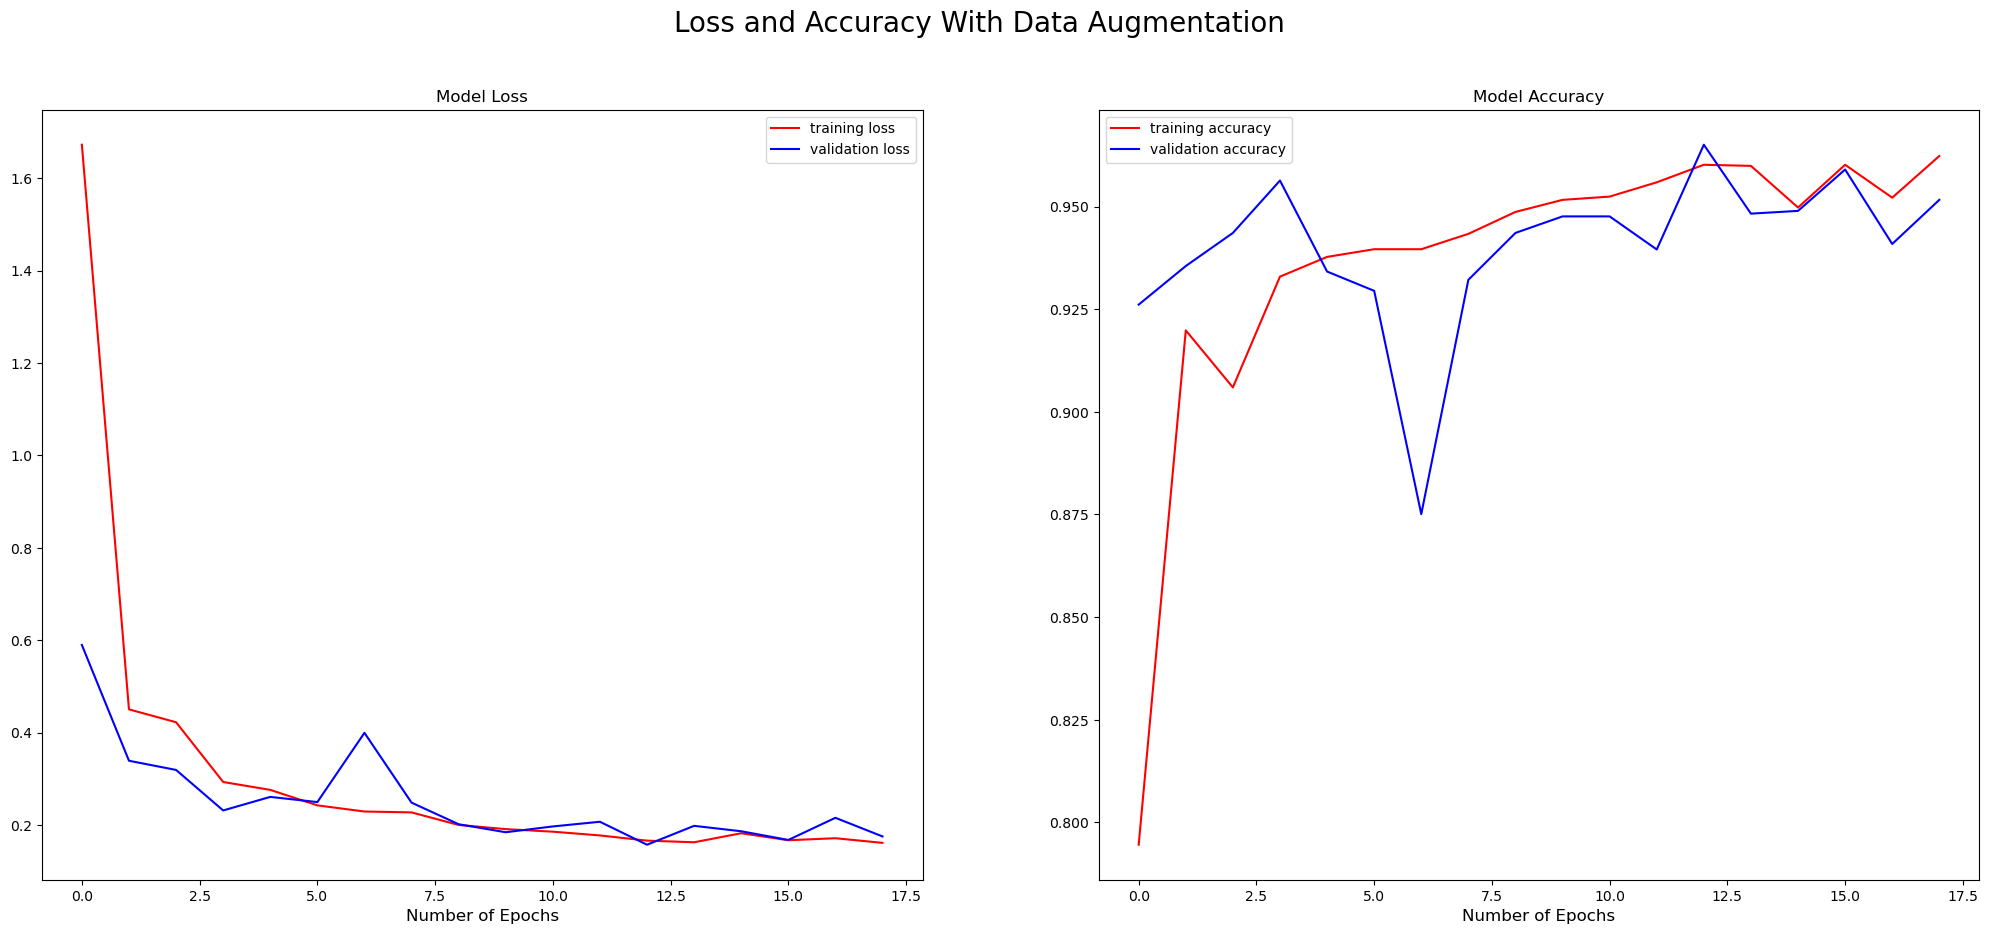

In [27]:
sigmoid_loss = final_hist.history['loss']
sigmoid_accuracy = final_hist.history['accuracy']
val_sigmoid_loss = final_hist.history['val_loss']
val_sigmoid_accuracy = final_hist.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
sns.lineplot(x=final_hist.epoch, y=sigmoid_loss, ax=ax1, color='r', label='training loss')
sns.lineplot(x=final_hist.epoch, y=sigmoid_accuracy, ax=ax2, color='r', label='training accuracy')
sns.lineplot(x=final_hist.epoch, y=val_sigmoid_loss, ax=ax1, color='b', label='validation loss')
sns.lineplot(x=final_hist.epoch, y=val_sigmoid_accuracy, ax=ax2, color='b', label='validation accuracy')
plt.suptitle('Loss and Accuracy With Data Augmentation', fontsize=20)
ax1.set_title('Model Loss', fontsize=12)
ax2.set_title('Model Accuracy', fontsize=12)
ax1.set_xlabel('Number of Epochs', loc='center', fontsize=12)
ax2.set_xlabel('Number of Epochs', loc='center', fontsize=12);

In [25]:
final_train_data = tf.keras.utils.image_dataset_from_directory('./Data/CellData/chest_xray/total_train/',
                                                               label_mode='binary')

Found 5232 files belonging to 2 classes.


In [26]:
final_model = Sequential([data_augmentation])

final_model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
final_model.add(MaxPooling2D())
final_model.add(Conv2D(32, (3,3), 1, activation='relu'))
final_model.add(MaxPooling2D())
final_model.add(Conv2D(16, (3,3), 1, activation='relu'))
final_model.add(MaxPooling2D())
final_model.add(Flatten())
final_model.add(Dense(256, activation='relu', kernel_regularizer=l2(l=.01)))
final_model.add(Dense(128, activation='relu', kernel_regularizer=l2(l=.01)))
final_model.add(Dense(1, activation='sigmoid'))

final_model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

#in order to add multiple callbacks, need to set learning rate via Keras
K.set_value(final_model.optimizer.lr, 1e-3)

In [ ]:


final_hist = final_model.fit(final_train_data, epochs=20, batch_size=32, validation_data=test_data, callbacks=[tensorboard_callback])

Epoch 1/20


2022-09-16 11:30:00.529704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - ETA: 0s - loss: 6.2716 - accuracy: 0.8041

2022-09-16 11:30:42.317315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


164/164 [==============================] - 43s 255ms/step - loss: 6.2716 - accuracy: 0.8041 - val_loss: 2.9916 - val_accuracy: 0.6250
Epoch 2/20
164/164 [==============================] - 43s 257ms/step - loss: 2.3311 - accuracy: 0.8272 - val_loss: 2.3432 - val_accuracy: 0.6250
Epoch 3/20
164/164 [==============================] - 43s 259ms/step - loss: 1.7812 - accuracy: 0.8385 - val_loss: 1.9266 - val_accuracy: 0.6250
Epoch 4/20
164/164 [==============================] - 43s 258ms/step - loss: 1.4700 - accuracy: 0.8467 - val_loss: 1.7081 - val_accuracy: 0.5881
Epoch 5/20
164/164 [==============================] - 42s 254ms/step - loss: 1.3026 - accuracy: 0.8526 - val_loss: 1.6754 - val_accuracy: 0.6426
Epoch 6/20
164/164 [==============================] - 43s 258ms/step - loss: 1.1813 - accuracy: 0.8568 - val_loss: 1.4400 - val_accuracy: 0.5817
Epoch 7/20
164/164 [==============================] - 42s 252ms/step - loss: 1.0270 - accuracy: 0.8597 - val_loss: 1.3140 - val_accuracy: 0.6

In [ ]:
sigmoid_loss = final_hist.history['loss']
sigmoid_accuracy = final_hist.history['accuracy']
val_sigmoid_loss = final_hist.history['val_loss']
val_sigmoid_accuracy = final_hist.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
sns.lineplot(x=final_hist.epoch, y=sigmoid_loss, ax=ax1, color='r', label='training loss')
sns.lineplot(x=final_hist.epoch, y=sigmoid_accuracy, ax=ax2, color='r', label='training accuracy')
sns.lineplot(x=final_hist.epoch, y=val_sigmoid_loss, ax=ax1, color='b', label='validation loss')
sns.lineplot(x=final_hist.epoch, y=val_sigmoid_accuracy, ax=ax2, color='b', label='validation accuracy')
plt.suptitle('Loss and Accuracy With Data Augmentation', fontsize=20)
ax1.set_title('Model Loss', fontsize=12)
ax2.set_title('Model Accuracy', fontsize=12)
ax1.set_xlabel('Number of Epochs', loc='center', fontsize=12)
ax2.set_xlabel('Number of Epochs', loc='center', fontsize=12);

# Final Model Evaluation

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test_data.as_numpy_iterator(): 
    X, y = batch
    yhat = final_model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print('final model precision on test data is:', pre.result(), '\n')
print('final model recall on test data is:', re.result(), '\n') 
print('final model accuracy on test data is:', acc.result(), '\n')

In [ ]:
final_model.evaluate(test_data)

# Pickling Model For Use

In [ ]:
# import joblib

# # use the built-in open() function to open a file
# output_file = open("predict_pneumonia.pkl", "wb") # "wb" means "write as bytes"
# # dump the variable's contents into the file
# joblib.dump(final_model, output_file)
# # close the file, ensuring nothing stays in the buffer
# output_file.close()

# Summary

Summary elements:

**Business and data understanding:** 
- We are using pediatric Xray images taken in 2018 to train the model. These images serve as a strong data set due to the number of images (over 5,000), and because the data is easily tagged as normal or pneumonia
**Data preparation**: 
- I took the mendeley dataset and further created a validation dataset to train the data upon, as well as only used the grayscale images. These steps allowed me to reduce computational power while also reserving a dataset to prove utility on unseen data.
**packages/libraries used**
- tensorflow and Keras were used to perform the modeling steps, and to build the convolutional neural network
- I used matplot and seaborn to visualize the loss and accuracy of the model as I iterated in order to effectively tune the model
**Modeling:**
- My neural net used 3 layers of convolutional neural networks
- The model was built using adam as the optimizer rather than SGD. I don't have a massive data set, and the loss/accuracy was better with the adam optimizer so I stayed with it for the final model
- I used an L2 regularizer since the model had overfitting issues I wanted to address
- I added a dropout layer at the end to make sure my model wasn't performing porrly/ensuring randomization allowed for better generalizations to reduce overfitting
Evaluation: how well did your final model perform?
 - final precision was
 - final recal was 
 - final accuracy was
 - my model's performance on test data (evaluate method) was 